<div style="width:90%;
            margin:10px;
            padding:8px;
            border:2px solid #FF0000;
            border-radius:20px;
            font-weight:bold;
            font-size:2.5em;
            text-align:center;">
The Space Shuttle Reentry Problem
</div>

<div style="width:90%;
            margin:9px;
            font-size:1em;">
            
*The Space Shuttle Reentry Problem:* We aim find the optimal trajectory of a space shuttle reentry while minimizing the angle of attack at the terminal point.
The problem is inspired from Chapter 6 of: [Practical Methods for Optimal Control and Estimation Using Nonlinear Programming, Second Edition](https://epubs.siam.org/doi/book/10.1137/1.9780898718577).                             
We solve the problem using the [JuMP](https://jump.dev/) and [OptimalControl](https://control-toolbox.org/OptimalControl.jl/stable/) packages in Julia then we compare the results.

1. [JuMP Formulation](#jump)
2. [OptimalControl Formulation](#oc)
3. [Comparison](#comp)


</div>

In [1]:
import Pkg
Pkg.activate("..")
include("./utils.jl");
using OptimalControlProblems
using Plots
using MKL
import HSL_jll

  Activating project at `c:\Users\hajje\Dropbox\PC\Desktop\Stage\COTS`


## 1. Solving with JuMP <a id='jump'></a>

In [ ]:
using JuMP, Ipopt

SpaceShuttleJMP = space_shuttle(JuMPBackend())

set_optimizer(SpaceShuttleJMP,Ipopt.Optimizer)
set_attribute(SpaceShuttleJMP, "print_level", 5)
set_optimizer_attribute(SpaceShuttleJMP,"tol",1e-8)
set_optimizer_attribute(SpaceShuttleJMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(SpaceShuttleJMP,"max_iter",1000)
set_optimizer_attribute(SpaceShuttleJMP,"mu_strategy","adaptive")
#set_attribute(SpaceShuttleJMP, "hsllib", HSL_jll.libhsl_path)
#set_attribute(SpaceShuttleJMP, "linear_solver", "ma57")
set_optimizer_attribute(SpaceShuttleJMP, "print_timing_statistics", "yes")
set_optimizer_attribute(SpaceShuttleJMP, "sb", "yes")

In [3]:
println("Solving...")
optimize!(SpaceShuttleJMP)
println()

# Display results
if termination_status(SpaceShuttleJMP) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(SpaceShuttleJMP) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(SpaceShuttleJMP) == MOI.TIME_LIMIT && has_values(SpaceShuttleJMP)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
# Show final cross-range of the solution
println(
    "Final latitude θ = ",
    round(objective_value(SpaceShuttleJMP) |> rad2deg; digits = 2),
    "°",
)
println()

scaled_h = SpaceShuttleJMP[:scaled_h]
scaled_v = SpaceShuttleJMP[:scaled_v]
ϕ = SpaceShuttleJMP[:ϕ]
θ = SpaceShuttleJMP[:θ]
γ = SpaceShuttleJMP[:γ]
ψ = SpaceShuttleJMP[:ψ]
Δt = SpaceShuttleJMP[:Δt]
ts = cumsum([0; value.(Δt)]);

Solving...
This is Ipopt version 3.14.16, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    21093
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    57228

Total number of variables............................:     4526
                     variables with only lower bounds:     1006
                variables with lower and upper bounds:     2514
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3021
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.25e+03 1.10e+00   0.0 0.00e+00    -  0.00e+00 0.00e

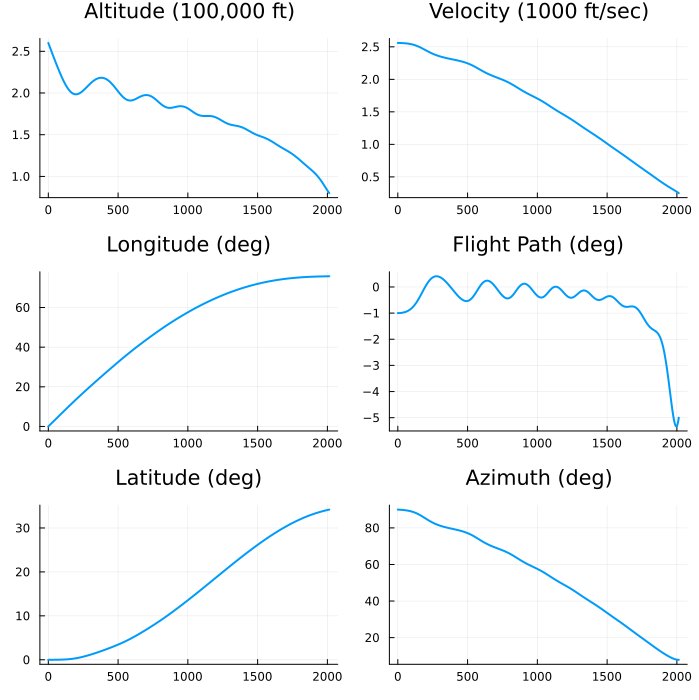

In [4]:
plt_altitude = plot(
    ts,
    value.(scaled_h);
    legend = nothing,
    title = "Altitude (100,000 ft)",
)
plt_longitude =
    plot(ts, rad2deg.(value.(ϕ)); legend = nothing, title = "Longitude (deg)")
plt_latitude =
    plot(ts, rad2deg.(value.(θ)); legend = nothing, title = "Latitude (deg)")
plt_velocity = plot(
    ts,
    value.(scaled_v);
    legend = nothing,
    title = "Velocity (1000 ft/sec)",
)
plt_flight_path =
    plot(ts, rad2deg.(value.(γ)); legend = nothing, title = "Flight Path (deg)")
plt_azimuth =
    plot(ts, rad2deg.(value.(ψ)); legend = nothing, title = "Azimuth (deg)")

plot(
    plt_altitude,
    plt_velocity,
    plt_longitude,
    plt_flight_path,
    plt_latitude,
    plt_azimuth;
    layout = grid(3, 2),
    linewidth = 2,
    size = (700, 700),
)

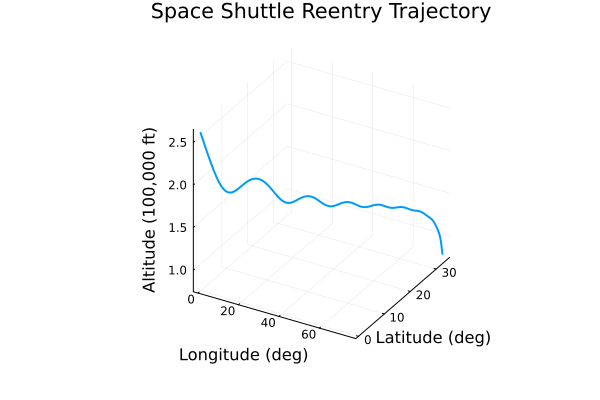

In [5]:
plot(
    rad2deg.(value.(ϕ)),
    rad2deg.(value.(θ)),
    value.(scaled_h);
    linewidth = 2,
    legend = nothing,
    title = "Space Shuttle Reentry Trajectory",
    xlabel = "Longitude (deg)",
    ylabel = "Latitude (deg)",
    zlabel = "Altitude (100,000 ft)",
)

## 1. Solving with OptimalControl <a id='oc'></a>

In [6]:
using OptimalControl, NLPModelsIpopt
docp, SpaceShuttleOC = space_shuttle(OptimalControlBackend();nh=501);

(CTDirect.DOCP(OptimalControlModel{Autonomous, Fixed}
  model_expression: Expr
  initial_time: Float64 0.0
  initial_time_name: String "0.0"
  final_time: Float64 2012.0
  final_time_name: String "2012.0"
  time_name: String "t"
  control_dimension: Int64 2
  control_components_names: Array{String}((2,))
  control_name: String "u"
  state_dimension: Int64 6
  state_components_names: Array{String}((6,))
  state_name: String "x"
  variable_dimension: Nothing nothing
  variable_components_names: Nothing nothing
  variable_name: Nothing nothing
  lagrange: Nothing nothing
  mayer: CTBase.Mayer{Fixed}
  criterion: Symbol max
  dynamics: CTBase.Dynamics{Autonomous, Fixed}
  constraints: Dict{Symbol, Tuple}
  dim_control_constraints: Int64 0
  dim_state_constraints: Int64 0
  dim_mixed_constraints: Int64 0
  dim_boundary_constraints: Int64 9
  dim_variable_constraints: Int64 0
  dim_control_range: Int64 2
  dim_state_range: Int64 4
  dim_variable_range: Int64 0
, (Real[], CTBase.var"#ξ#41"(Co

In [ ]:
# Solve the problem
nlp_sol = NLPModelsIpopt.ipopt(
    SpaceShuttleOC;
    print_level=5,
    tol=1e-8,
    mu_strategy="adaptive",
    sb="yes",
    constr_viol_tol=1e-6,
    max_iter=1000,
    print_timing_statistics="yes",
    #linear_solver="ma57",
    #hsllib=HSL_jll.libhsl_path,
)

4. Showing the results

In [ ]:
rad2deg(sol.objective)

In [ ]:
plot(sol)

In [ ]:
using JuMP
Δt = ones(n)*(tf/(n-1))
ts = cumsum([0; value.(Δt)])[1:end-1]
x = [sol.state(t) for t in ts]
scaled_h = [x[i][1] for i in 1:length(x)]
ϕ = [x[i][2] for i in 1:length(x)]
θ = [x[i][3] for i in 1:length(x)]
plot(
    rad2deg.(ϕ),
    rad2deg.(θ),
    scaled_h;
    linewidth = 2,
    legend = nothing,
    title = "Space Shuttle Reentry Trajectory",
    xlabel = "Longitude (deg)",
    ylabel = "Latitude (deg)",
    zlabel = "Altitude (100,000 ft)",
)